In [1]:
import glob
import pandas as pd
from datetime import datetime

# Functions

In [2]:
def processHeartRate_DATAFRAME(df):
    
    df['Date'] = pd.to_datetime(df['dateTime']).dt.date
    df['Time'] = pd.to_datetime(df['dateTime']).dt.time
    
    # Copying the dict values to the dataframe, based on:
    # https://stackoverflow.com/questions/29681906/python-pandas-dataframe-from-series-of-dict
    
    temp_df = pd.DataFrame(list(df['value']))
    df['BPM']=temp_df['bpm']
    df['Confidence']=temp_df['confidence']
 
    # Remove initial, final and some other low-confidnece readings
    # Then re-index to prevent possible problems

    df=df[df[:]['Confidence']>1]  
    dfNew=df.reset_index(drop=True) # new continuos index, also drops old index        
    
    return dfNew

In [3]:
def calculateSummeries(df):
    Date=df.iloc[0]['Date'] # Assumes that this json is for a single date
    Duration= datetime.combine( Date, df['Time'].max() ) - datetime.combine( Date,df['Time'].min() )
    MeanBPM=round(df['BPM'].mean(),0)
    MaxBPM=round(df['BPM'].max(),0)
    
    s= str(df.iloc[0]['Date']) + ' ' + str(Duration) + ' ' + str(MeanBPM) + ' ' + str(MaxBPM)   
    Summaries.append(s)

In [4]:
# Each json heart rate file covers a day; this function identifies days with more than one activity
# Uses a hurisitc, that there is no data for more than 20 minutes, to divide into a new activity

def identifyBreak_inTime(df):
    
    breakExists=False
    for i in range(len(df)-1):
        delta=df.iloc[i+1]['dateTime'] - df.iloc[i]['dateTime']
        if (delta>pd.Timedelta("20 minutes")):
            print('BREAK ',i,df.iloc[i]['Time'],df.iloc[i+1]['Time'])
            breakExists=True
            break
    return breakExists,i

# Main

In [5]:
# Global parameters and variables

start=289           # File number to start from 
end=292           # Process and plot n files
n_plots=end-start

DFs=[]
Summaries=[]

In [6]:
files=glob.glob("FITBIT\heart_rate*.json")

print('all',len(files),'start',start,'end+1',end,'files/plots',n_plots)
filesToRead=files[start:end]

all 293 start 289 end+1 292 files/plots 3


In [7]:
# Process the files, usually one activity per file
# Checks also if time is broken and then creates a new activity from that file

# The reindexing is needed to prevent warrnings, see:
# http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

readNewFile=True
i=-1
while ( (i+1)< len(filesToRead) ) or (not readNewFile): 
        
    if (readNewFile):
        i+=1
        df0=pd.read_json(filesToRead[i])
        print('Main',i,filesToRead[i])
        
    df=processHeartRate_DATAFRAME(df0)
        
    breakExists,breakIndex=identifyBreak_inTime(df)
    if (breakExists):
        df1=df[0:breakIndex+1]
        readNewFile=False
        df0=df[breakIndex+1:].reset_index(drop=True)
        n_plots+=1
    else:
        df1=df
        readNewFile=True
    
    DFs.append(df1)
    calculateSummeries(df1)

Main 0 FITBIT\heart_rate-2021-02-28.json
Main 1 FITBIT\heart_rate-2021-03-01.json
BREAK  863 10:39:22 14:32:42
BREAK  205 14:49:34 16:20:50
Main 2 FITBIT\heart_rate-2021-03-02.json
BREAK  1089 11:17:23 15:15:25
BREAK  4 15:15:45 16:58:34


# Plot

n_plots 7


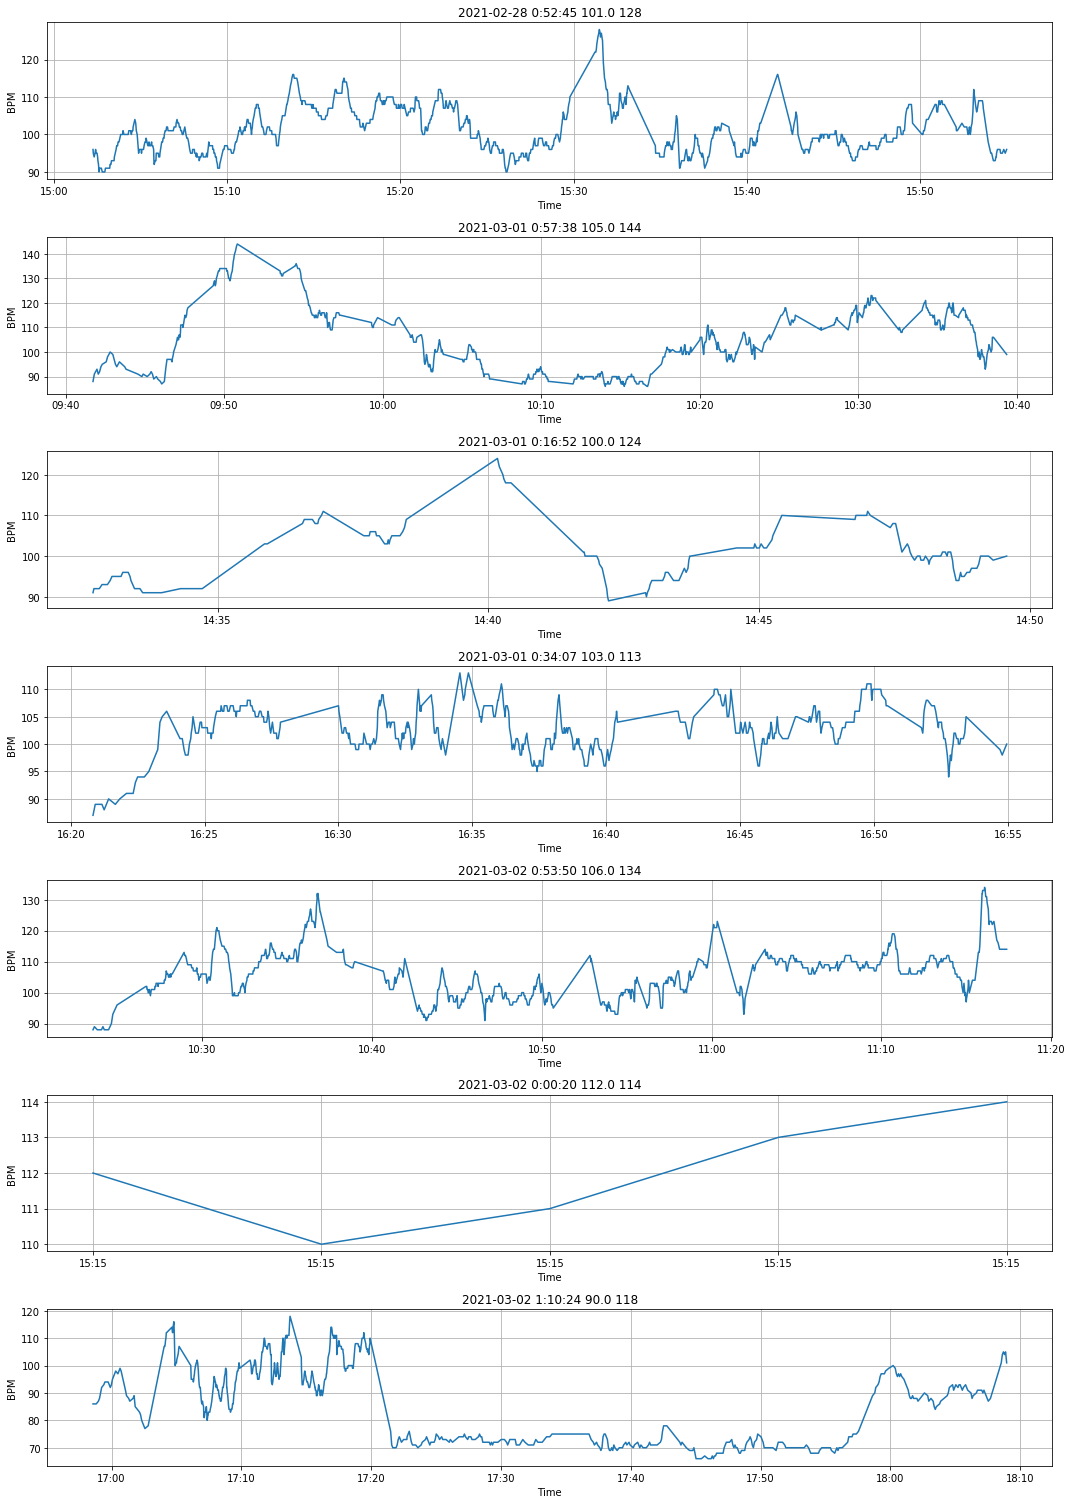

In [8]:
# From: https://matplotlib.org/stable/gallery/lines_bars_and_markers/cohere.html
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

print('n_plots',n_plots)
fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(15, 3*n_plots) )

myFormat = DateFormatter("%H:%M")
register_matplotlib_converters(myFormat)

for i in range(n_plots):
    df=DFs[i]
    #print('Plot i',i)
    axs[i].plot(df['dateTime'], df['BPM'])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('BPM')
    axs[i].set_title( Summaries[i] )
    axs[i].grid(True)
    axs[i].xaxis.set_major_formatter(myFormat)
            
fig.tight_layout()
plt.show()